# Load Data

In [1]:
import pandas as pd

data = pd.read_csv('dataset.csv')
data = data.iloc[:, :5]
new_column_names = {
    'MONATSZAHL': 'Category',
    'AUSPRAEGUNG': 'AccidentType',
    'JAHR': 'Year',
    'MONAT': 'Month',
    'WERT': 'Value'
}
data = data.rename(columns=new_column_names)

data.head()

,Category,AccidentType,Year,Month,Value
0,Alkoholunfälle,insgesamt,2024,202401,NaN
1,Alkoholunfälle,insgesamt,2024,202402,NaN
2,Alkoholunfälle,insgesamt,2024,202403,NaN
3,Alkoholunfälle,insgesamt,2024,202404,NaN
4,Alkoholunfälle,insgesamt,2024,202405,NaN


In [2]:
ground_truth = data[data['Category'] == "Alkoholunfälle"]
ground_truth = ground_truth[ground_truth['AccidentType'] == "insgesamt"]
ground_truth = ground_truth[ground_truth["Month"] == "202101"]
ground_truth

,Category,AccidentType,Year,Month,Value
38,Alkoholunfälle,insgesamt,2021,202101,16.0


In [3]:
data = data[data['Month'] <= "202101"]
data = data[data['Month'] != "Summe"]
data = data.sort_values(by='Month')
data.head()

,Category,AccidentType,Year,Month,Value
310,Alkoholunfälle,insgesamt,2000,200001,78.0
1920,Verkehrsunfälle,mit Personenschäden,2000,200001,321.0
632,Alkoholunfälle,Verletzte und Getötete,2000,200001,37.0
1598,Verkehrsunfälle,insgesamt,2000,200001,3448.0
2242,Verkehrsunfälle,Verletzte und Getötete,2000,200001,434.0


# Visualization

In [59]:
unique_categories = data['Category'].unique()
print("Type of Accident: ", unique_categories)

Type of Accident:  ['Fluchtunfälle' 'Verkehrsunfälle' 'Alkoholunfälle']


In [60]:
filtered_data = {category: data[data['Category'] == category] for category in unique_categories}

## Plot for Different Categories in Subplots

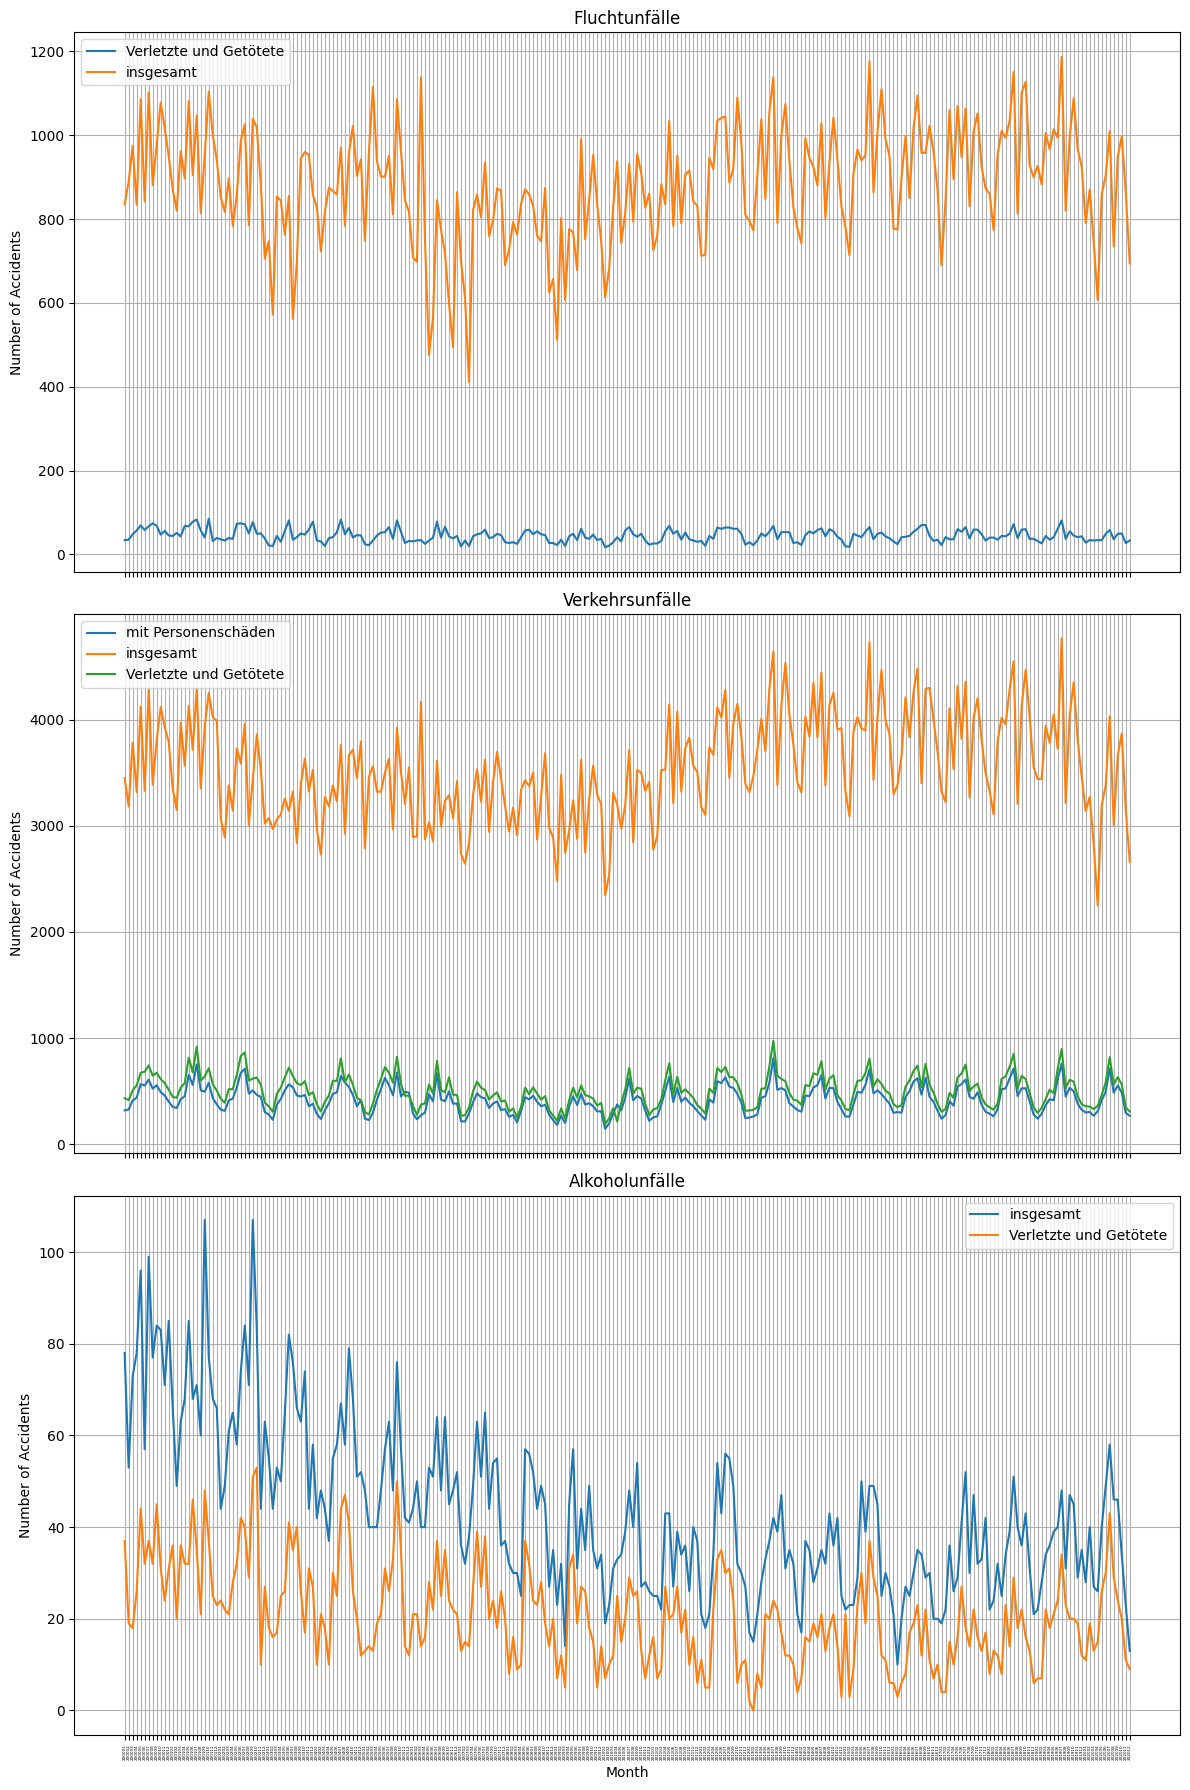

In [61]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18), sharex=True)

# Plot each category in a separate subplot with multiple accident types
for ax, category in zip(axes, unique_categories):
    category_data = data[data['Category'] == category]
    for accident_type in category_data['AccidentType'].unique():
        accident_data = category_data[category_data['AccidentType'] == accident_type]
        ax.plot(accident_data['Month'], accident_data['Value'], label=accident_type)
    ax.set_title(category)
    ax.set_ylabel('Number of Accidents')
    ax.legend()
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)

plt.xlabel('Month')
plt.xticks(fontsize=3)
plt.tight_layout()
plt.show()

## Plot the Total Number of Accidents

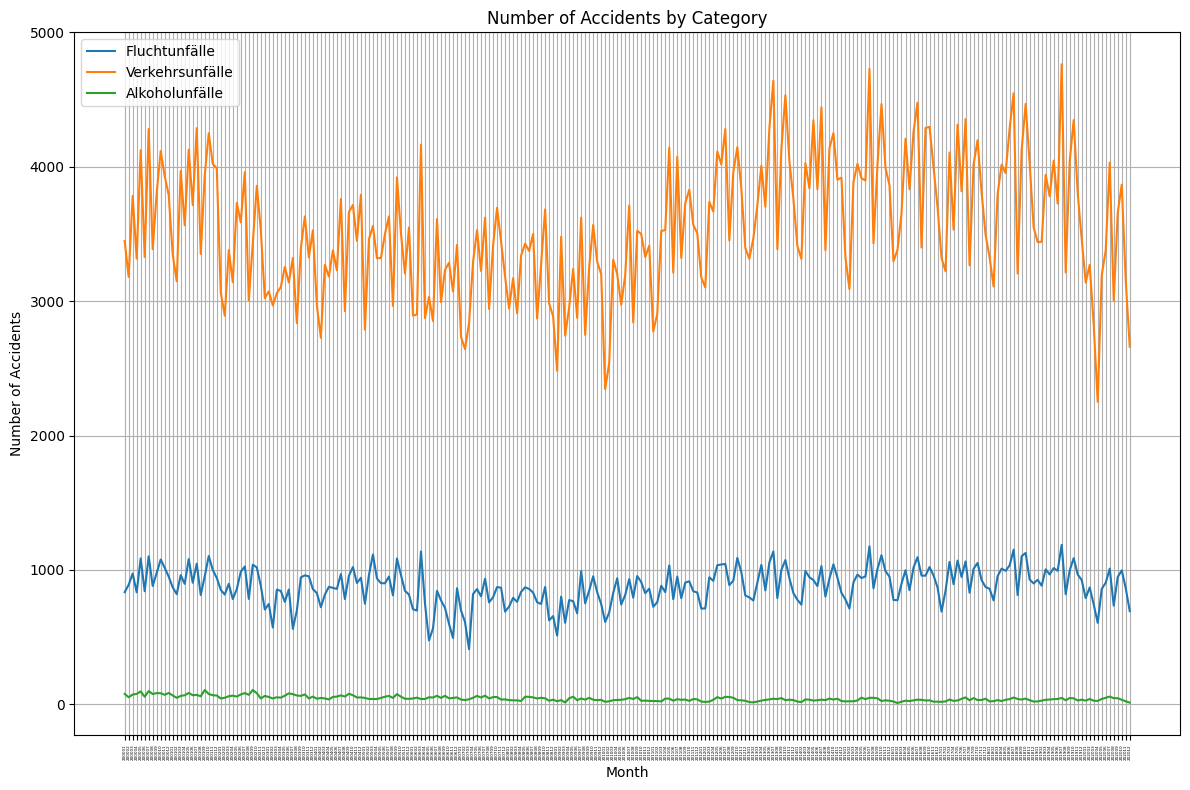

In [62]:
data_insgesamt = data[data['AccidentType'] == 'insgesamt']

plt.figure(figsize=(12, 8))

for category in unique_categories:
    category_data = data_insgesamt[data_insgesamt['Category'] == category]
    plt.plot(category_data['Month'], category_data['Value'], label=category)

plt.title('Number of Accidents by Category')
plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.legend()
plt.xticks(fontsize=3, rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# Data Pre-processing

In [4]:
# Convert Year and Month columns into a single column
# representing the month number relative to the start month (January 2000)

def convert_to_month_number(row):
    year = int(row['Year'])
    month = int(row['Month'][4:])
    return (year - 2000) * 12 + (month - 1) + 1

data['MonthNumber'] = data.apply(convert_to_month_number, axis=1)
data = data.drop(columns=['Year', 'Month'])
data.head()

,Category,AccidentType,Value,MonthNumber
310,Alkoholunfälle,insgesamt,78.0,1
1920,Verkehrsunfälle,mit Personenschäden,321.0,1
632,Alkoholunfälle,Verletzte und Getötete,37.0,1
1598,Verkehrsunfälle,insgesamt,3448.0,1
2242,Verkehrsunfälle,Verletzte und Getötete,434.0,1


# Predict for

Category: 'Alkoholunfälle'

Type: 'insgesamt

Year: '2021'

Month: '01'

## Model 0: ARIMA with only Alkoholunfälle insgesamt data

In [322]:
data_category = data[data['Category'] == 'Alkoholunfälle']
data_category = data_category[data_category["AccidentType"] == "insgesamt"]

data_category = data_category[['MonthNumber', 'Value']]
data_category.set_index('MonthNumber', inplace=True)
data_category = data_category.sort_index()

train_size = len(data_category) - 13
train_data = data_category.iloc[:train_size]
validation_data = data_category.iloc[train_size: -1]
test_data = data_category.iloc[-1]

from pmdarima import auto_arima
model = auto_arima(train_data, seasonal=False, trace=True, stepwise=True, alpha=0.01)

forecast_steps = len(validation_data)
forecast = model.predict(n_periods=forecast_steps)
forecast_index = validation_data.index

mse = mean_squared_error(validation_data['Value'], forecast)
print(f'Mean Squared Error (MSE) on Validation Set: {mse:.2f}')

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1877.350, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2538.729, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1913.528, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2316.593, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1861.450, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2189.517, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1873.350, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1852.381, Time=0.25 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2114.365, Time=0.19 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1848.904, Time=0.55 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=0.95 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=0.98 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=1847.217, Time=0.58 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=2057.798, Time=0.87 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=1

d:\anaconda\anaconda\envs\i2dl\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda\anaconda\envs\i2dl\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [330]:
forecast = model.predict(n_periods=13)
print(f"Predicted Result: {forecast.iloc[-1]}, Ground Truth: {test_data['Value']}")
mse = mean_squared_error([[forecast.iloc[-1]]], test_data)
print(f'Mean Squared Error (MSE) on Test Set: {mse:.2f}')

Predicted Result: 36.32889258231071, Ground Truth: 16.0
Mean Squared Error (MSE) on Test Set: 413.26


d:\anaconda\anaconda\envs\i2dl\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\anaconda\anaconda\envs\i2dl\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


## Model 1: LSTM Using only Alkoholunfälle insgesamt data

In [232]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_insgesamt_alkohol)

def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:i + sequence_length]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 8
X, y = create_sequences(scaled_data, sequence_length)

X_train, X_valid, X_test = X[:-13], X[-13:-1], X[-1:]
y_train, y_valid, y_test = y[:-13], y[-13:-1], y[-1:]

In [233]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_split=0.1, verbose=1)

Epoch 1/500


d:\anaconda\anaconda\envs\i2dl\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - loss: 0.1589 - val_loss: 0.0649
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1330 - val_loss: 0.0538
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1181 - val_loss: 0.0423
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0935 - val_loss: 0.0311
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0758 - val_loss: 0.0210
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0582 - val_loss: 0.0130
Epoch 7/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0384 - val_loss: 0.0090
Epoch 8/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0240 - val_loss: 0.0108
Epoch 9/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0197 - val_loss: 0.0162
Epoch 10/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0242 - val_loss: 0.0176
Epoch 11/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0225 - val_loss: 0.0135
Epoch 12/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0207 - val_loss: 0.0102


In [235]:
y_test_pred = model.predict(X_test)
y_test_pred = scaler.inverse_transform(y_test_pred)
y_test_inv = scaler.inverse_transform(y_test)
mse = mean_squared_error(y_test_pred, y_test_inv)
print(f"Predicted Result: {y_test_pred}")
print(f'Mean Squared Error (MSE) on test Set: {mse:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
Predicted Result: [[20.193003]]
Mean Squared Error (MSE) on test Set: 51.74


## Model 2: LSTM Using All Insgesamt Value

In [5]:
df = data[data["AccidentType"] == "insgesamt"]
df1 = df[df["Category"] == "Alkoholunfälle"]
df1 = df1.rename(columns={"Value" : "Alkoholunfälle"})
df2 = df[df["Category"] == "Verkehrsunfälle"]
df2 = df2.rename(columns={"Value" : "Verkehrsunfälle"})
df3 = df[df["Category"] == "Fluchtunfälle"]
df3 = df3.rename(columns={"Value" : "Fluchtunfälle"})

data2 = pd.merge(df1, df2, on=['MonthNumber'])
data2 = pd.merge(data2, df3, on=['MonthNumber'])
data2 = data2[['MonthNumber', 'Alkoholunfälle', 'Verkehrsunfälle', 'Fluchtunfälle']]
data2.head()

,MonthNumber,Alkoholunfälle,Verkehrsunfälle,Fluchtunfälle
0,1,78.0,3448.0,835.0
1,2,53.0,3181.0,890.0
2,3,73.0,3783.0,974.0
3,4,78.0,3317.0,834.0
4,5,96.0,4123.0,1086.0


In [53]:
data2.to_csv('historical_data.csv', index=False)

In [8]:
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:i + sequence_length]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [31]:
sequence_length = 8
test_size = 1
val_size = 12
train_size = len(df) - test_size - val_size

df = data2

import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Alkoholunfälle', 'Verkehrsunfälle', 'Fluchtunfälle']])
train_sequences, train_targets = create_sequences(scaled_data[:train_size], sequence_length)
val_sequences, val_targets = create_sequences(scaled_data[train_size - sequence_length:train_size + val_size], sequence_length)
test_sequences, test_targets = create_sequences(scaled_data[train_size + val_size - sequence_length:], sequence_length)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(20, activation='relu', input_shape=(sequence_length, 3)))
model.add(Dense(3))
model.compile(optimizer='adam', loss='mse')

history = model.fit(train_sequences, train_targets, epochs=350, batch_size=16, validation_data=(val_sequences, val_targets))

d:\anaconda\anaconda\envs\i2dl\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/350
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.2299 - val_loss: 0.1192
Epoch 2/350
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1627 - val_loss: 0.0817
Epoch 3/350
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1061 - val_loss: 0.0563
Epoch 4/350
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0579 - val_loss: 0.0399
Epoch 5/350
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0357 - val_loss: 0.0387
Epoch 6/350
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0297 - val_loss: 0.0397
Epoch 7/350
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0306 - val_loss: 0.0388
Epoch 8/350
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0275 - val_loss: 0.0368
Epoch 9/350
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0284 - val_loss: 0.0387
Epoch 10/350
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0249 - val_loss: 0.0385
Epoch 11/350
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0269 - val_loss: 0.0375
Epoch 12/350
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - l

In [32]:
from sklearn.metrics import mean_squared_error
predictions = model.predict(test_sequences)

scaler_target = MinMaxScaler()
scaler_target.fit(df[['Alkoholunfälle', 'Verkehrsunfälle', 'Fluchtunfälle']])
test_targets_inv = scaler_target.inverse_transform(test_targets)
predictions_inv = scaler_target.inverse_transform(predictions)

mse = mean_squared_error([[test_targets_inv[0][0]]], [[predictions_inv[0][0]]])
print(f"Predicted Result: {predictions_inv[0][0]}, Ground Truth: {test_targets_inv[0][0]}")
print(f'Mean Squared Error (MSE) on Test Set: {mse:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Predicted Result: 15.238390922546387, Ground Truth: 16.0
Mean Squared Error (MSE) on Test Set: 0.58


# Prediction Visualisation

In [46]:
pred1 = model.predict(train_sequences)[:, 0]
pred2 = model.predict(val_sequences)[:, 0]
pred3 = model.predict(test_sequences)[:, 0]
pred = np.concatenate((pred1, pred2, pred3))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [47]:
target1 = train_targets[:, 0]
target2 = val_targets[:, 0]
target3 = test_targets[:, 0]
target = np.concatenate((target1, target2, target3))

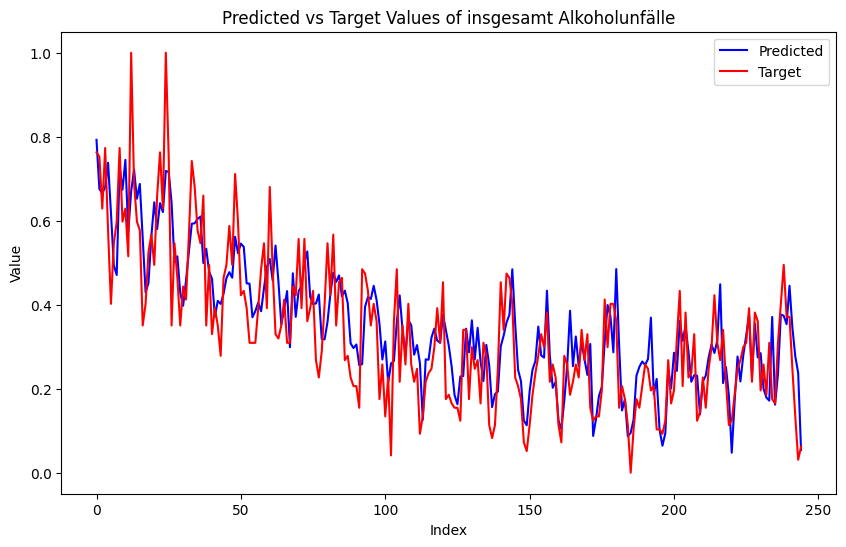

In [49]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(pred, label='Predicted', color='blue')
plt.plot(target, label='Target', color='red')


plt.title('Predicted vs Target Values of insgesamt Alkoholunfälle')
plt.xlabel('Index')
plt.ylabel('Value')

plt.legend()
plt.show()

# Deployment

In [52]:
import joblib

model.save('lstm_model.keras')
scaler_filename = "scaler.save"
joblib.dump(scaler, scaler_filename)

['scaler.save']

In [ ]:
from flask import Flask, request, jsonify
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import joblib

# Load the model and the scaler
model = load_model('lstm_model.keras')
scaler = joblib.load('scaler.save')

# Create the Flask app
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    year = data['year']
    month = data['month']

    # Convert year and month to MonthNumber
    base_year = 2000
    base_month = 1
    month_number = (year - base_year) * 12 + (month - base_month) + 1

    # Generate the historical data needed to create the sequence
    input_df = pd.read_csv('historical_data.csv')
    
    # Normalize the data
    scaled_input = scaler.transform(input_df[['Alkoholunfälle', 'Verkehrsunfälle', 'Fluchtunfälle']])

    # Create the input sequence for the LSTM model
    sequence_length = 8
    if len(scaled_input) < sequence_length:
        return jsonify({'error': 'Not enough data to create a sequence'})

    input_sequence = np.array([scaled_input[-sequence_length:]])

    # Make a prediction
    prediction_scaled = model.predict(input_sequence)
    prediction = scaler.inverse_transform(prediction_scaled)[0]

    return jsonify({
        'prediction': prediction[0]
    })

if __name__ == '__main__':
    app.run(debug=True)